# Neural Network to Classify MNIST Digits

### Imports

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Load Test Data (Legacy Method)

In [2]:
mnist = input_data.read_data_sets("MNIST Data/", one_hot=True, validation_size=0)
print(f"Training set size: {mnist.train.num_examples}")
print(f"Test set size: {mnist.test.num_examples}")
print(f"Validation set size: {mnist.validation.num_examples}")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST Data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST Data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST Data/t10k-images-idx3-ubyte.gz
Extracting MNIST Data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Training set size: 60000
Test set size: 10000
Validation set size: 0


### Display Sample Images

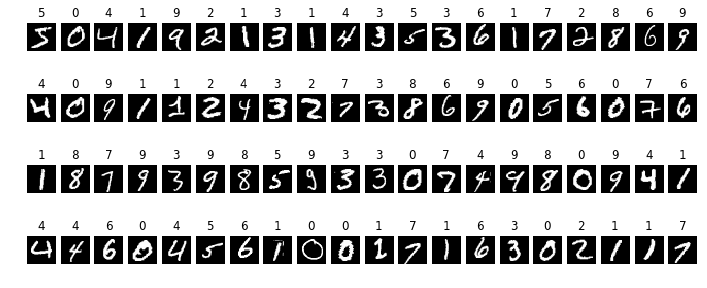

In [3]:
rows = 4
cols = 20
f, axes = plt.subplots(rows, cols, figsize=(12,5)) # image size is in inches
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        axes[i, j].imshow(mnist.train.images[index].reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f"{mnist.train.labels[index].argmax()}")
        axes[i, j].axis('off')
plt.show()

### Define Graph

In [4]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [5]:
with tf.name_scope('Inputs'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='image') # Nx784
    y = tf.placeholder(tf.float32, shape=[None, 10], name='label')  # Nx10
with tf.name_scope('LinearModel'):
    W = tf.Variable(tf.zeros([784, 10]), name='weights')  # 784x10
    b = tf.Variable(tf.zeros([10]), name='bias') # 1x10
    y_hat = tf.matmul(x, W) + b # Nx10
    variable_summaries(y_hat)

with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat, name='softmax'))
    tf.summary.scalar('loss', loss)
with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
summarize_all = tf.summary.merge_all()

# Accuracy calculation
is_correct = tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1)) # compare index of entry with largest value
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32)) # compute % of correct predictions

### Run

In [6]:
start_time = time.time()
init = tf.global_variables_initializer()
num_iterations = 1000
batch_size = 100
log_path = './TBLogs/'
with tf.Session() as sess:
    tbWriter = tf.summary.FileWriter(log_path, sess.graph)
    sess.run(init)    
    for i in range(num_iterations):
        # Retrieve images and labels as [batch_size, 784] and [batch_size, 10] arrays
        images, labels = mnist.train.next_batch(batch_size)
        _, summary = sess.run([optimizer, summarize_all], feed_dict={x:images, y:labels})
        tbWriter.add_summary(summary, i)
        if (i % 100 == 0) or (i == num_iterations-1):
            l = sess.run(loss, feed_dict={x:images, y:labels})
            end_time = time.time()
            acc = sess.run(accuracy, feed_dict={y:labels, x:images})
            print(f"Step {i} complete after {end_time-start_time:.1f}s, with loss {l:.2f} and training accuracy {acc*100:.1f}%.")
    tbWriter.close()
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.1f}s.")
    # Show accuracy on both data sets
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:mnist.train.images, y:mnist.train.labels})
    print(f"Accuracy on training data: {acc*100:.1f}%.")
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:mnist.test.images, y:mnist.test.labels})
    print(f"Accuracy on test data: {acc*100:.1f}%.")    


Step 0 complete after 0.4s, with loss 1.72 and training accuracy 32.0%.
Step 100 complete after 0.5s, with loss 0.30 and training accuracy 97.0%.
Step 200 complete after 0.6s, with loss 0.29 and training accuracy 93.0%.
Step 300 complete after 0.7s, with loss 0.45 and training accuracy 85.0%.
Step 400 complete after 0.8s, with loss 0.30 and training accuracy 91.0%.
Step 500 complete after 0.9s, with loss 0.39 and training accuracy 94.0%.
Step 600 complete after 1.2s, with loss 0.29 and training accuracy 90.0%.
Step 700 complete after 1.3s, with loss 0.23 and training accuracy 91.0%.
Step 800 complete after 1.4s, with loss 0.37 and training accuracy 91.0%.
Step 900 complete after 1.5s, with loss 0.20 and training accuracy 95.0%.
Step 999 complete after 1.6s, with loss 0.40 and training accuracy 93.0%.
Elapsed time: 1.8s.
Accuracy on training data: 91.5%.
Accuracy on test data: 91.6%.


### Check Prediction on Test Set (format: prediction#label)

Number of errors=7


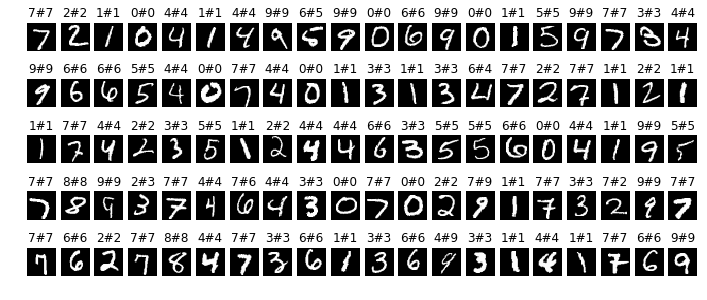

In [7]:
rows = 5
cols = 20
errors = 0
f, axes = plt.subplots(rows, cols, figsize=(12,5)) # image size is in inches
for i in range(rows):
    for j in range(cols):
        index = i*cols + j
        image = mnist.test.images[index]
        output = np.matmul(image, weights) + bias # score = image * weights + bias
        probabilities = np.exp(output) / np.exp(output).sum() # activation function converts scores to probabilities
        if (output.argmax() != mnist.test.labels[index].argmax()):
            errors += 1
        axes[i, j].imshow(image.reshape((28, 28)), cmap='gray')
        axes[i, j].set_title(f"{output.argmax()}#{mnist.test.labels[index].argmax()}")
        axes[i, j].axis('off')
print(f"Number of errors={errors}")
plt.show()